# **Income Classification**



#**Background**
The goal of this project is to build a model that will predict whether a person earns more than 50K per year.
* Reference - https://www.kaggle.com/datasets/lodetomasi1995/income-classification
 
  The data set contains information about people and their income.

#**Import Libraries**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import sys
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

#**Import Data**

In [ ]:
if 'google.colab' in sys.modules:
    from google.colab import files
    uploaded = files.upload()

Saving income_evaluation.csv to income_evaluation.csv


In [ ]:
df = pd.read_csv('income_evaluation.csv')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
df.shape

(32561, 15)

In [ ]:
len_df = len(df)

#**Data Cleaning**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              32561 non-null  int64 
 1    workclass       32561 non-null  object
 2    fnlwgt          32561 non-null  int64 
 3    education       32561 non-null  object
 4    education-num   32561 non-null  int64 
 5    marital-status  32561 non-null  object
 6    occupation      32561 non-null  object
 7    relationship    32561 non-null  object
 8    race            32561 non-null  object
 9    sex             32561 non-null  object
 10   capital-gain    32561 non-null  int64 
 11   capital-loss    32561 non-null  int64 
 12   hours-per-week  32561 non-null  int64 
 13   native-country  32561 non-null  object
 14   income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


**Check NaN Values**

In [ ]:
df.isnull().sum()

age                0
 workclass         0
 fnlwgt            0
 education         0
 education-num     0
 marital-status    0
 occupation        0
 relationship      0
 race              0
 sex               0
 capital-gain      0
 capital-loss      0
 hours-per-week    0
 native-country    0
 income            0
dtype: int64

**Handle Missing Values**

In [ ]:
cat_list = [cat for cat in df.columns if df[cat].dtype=='O']

for column in cat_list:
    print ('Unique values per column -'+str(column) + ':')
    print('\t')
    print (df[column].unique())
    print('---')
    print('\t')

Unique values per column - workclass:
	
[' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked']
---
	
Unique values per column - education:
	
[' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' Assoc-voc' ' 7th-8th' ' Doctorate' ' Prof-school'
 ' 5th-6th' ' 10th' ' 1st-4th' ' Preschool' ' 12th']
---
	
Unique values per column - marital-status:
	
[' Never-married' ' Married-civ-spouse' ' Divorced'
 ' Married-spouse-absent' ' Separated' ' Married-AF-spouse' ' Widowed']
---
	
Unique values per column - occupation:
	
[' Adm-clerical' ' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service' ' Sales' ' Craft-repair' ' Transport-moving'
 ' Farming-fishing' ' Machine-op-inspct' ' Tech-support' ' ?'
 ' Protective-serv' ' Armed-Forces' ' Priv-house-serv']
---
	
Unique values per column - relationship:
	
[' Not-in-family' ' Husband' ' Wife' ' Own-child' ' Unmarried'
 ' Other-r

In [ ]:
# find categorical columns with missing values
for col in cat_list:
    if df[col].isnull().mean()>0:
        print(col, (df[col].isnull().mean()))

In [ ]:
# drop missing values
df[[' workclass',' occupation',' native-country']] = df[[' workclass',' occupation',' native-country']].replace(' ?',np.NaN)
df = df.dropna(how='any',axis=0)

# alternatively we can use imputation, for example most frequent value:
# df['workclass'].fillna(df['workclass'].mode()[0], inplace=True)

In [ ]:
# Handle Duplications
df.drop_duplicates(inplace=True)

In [ ]:
# Display Clean Dataset Size
print("clean_dataset_size:",100*len(df)/len_df,"%")

clean_dataset_size: 92.56165351187003 %


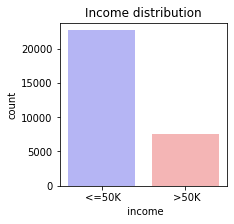

In [ ]:
# Handle Imbalanced Data
f, plot = plt.subplots(figsize=(3, 3))
plot = sns.countplot(x=" income", data=df, palette="bwr").set_title("Income distribution")
plt.show()

*We can see that there is an imbalanced data issue (models tend to bias towards the larger class i.e. large portion of the data).*

**Methods to balance datasets:**<br>
1. **Undersampling:**
* Randomly selecting observations from the majority class and removing them from the training dataset
* Can be used with large dataset, disadvantage is that we are removing data that may be valuable which then can lead to underfitting and poor generalization to the test set.
---
2. **Oversampling:**<br>
* Randomly selecting observations from the minority class, with replacement, and adding them to the training dataset. 
* Can be a good choice when you don’t have a big dataset to work with
---
3. **SMOTE Over Sampling (Synthetic Minority Oversampling Technique):**
* Works by creating synthetic samples from the minor class instead of creating copies.
* Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observations.
  

In [ ]:
# SMOTE will be applied later on the training data set

#**EDA**

**Sex column**

Text(0.5, 1.0, 'Sex distribution')

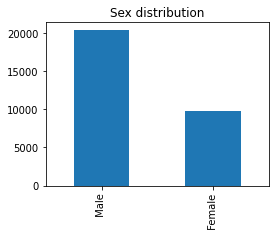

In [ ]:
f, plot = plt.subplots(figsize=(4, 3))
df[' sex'].value_counts().plot.bar()
plot.set_title("Sex distribution")

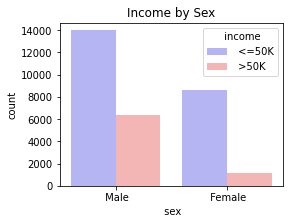

In [ ]:
f, plot = plt.subplots(figsize=(4, 3))
plot = sns.countplot(x=" sex", data=df, hue=" income", palette="bwr")
plot.set_title("Income by Sex")
plt.show()

*We can see that the proportion of ">50k" group of total, is much higher for males than females, suggesting males are making more money.*

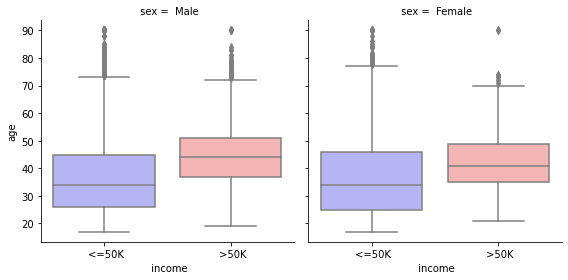

In [ ]:
ax = sns.catplot(x=" income", y="age", col=" sex", data=df, kind="box", height=4, palette="bwr")
plt.show()

*We can see that older people makes more money than younger people.*

**Education column**

Text(0.5, 1.0, 'Education distribution')

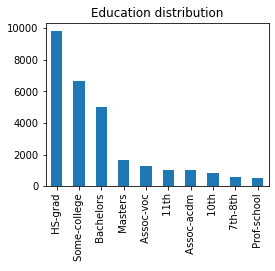

In [ ]:
f, plot = plt.subplots(figsize=(4, 3))
df[' education'].value_counts().head(10).plot.bar()
plot.set_title("Education distribution")

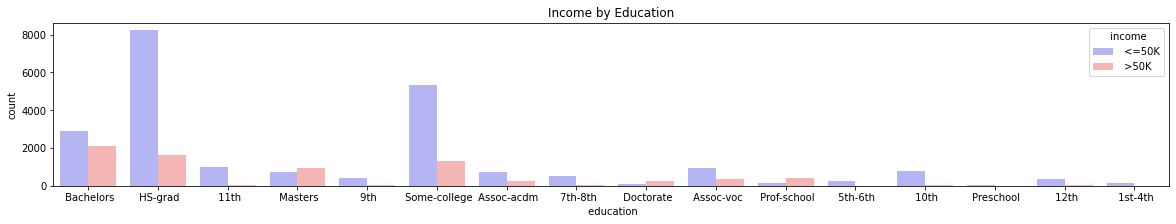

In [ ]:
f, plot = plt.subplots(figsize=(20, 3))
plot = sns.countplot(x=" education", data=df, hue=" income", palette="bwr")
plot.set_title("Income by Education")
plt.show()

*For ">50k" group, we can see that bachelors are significantly more frequent than the rest of theeducation categories, suggesting positive correlation between the two.*

**Race column**

Text(0.5, 1.0, 'Race distribution')

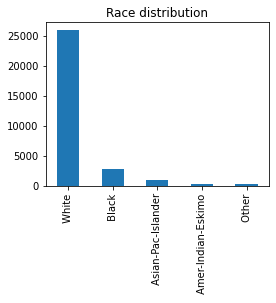

In [ ]:
f, plot = plt.subplots(figsize=(4, 3))
df[' race'].value_counts().plot.bar()
plot.set_title("Race distribution")

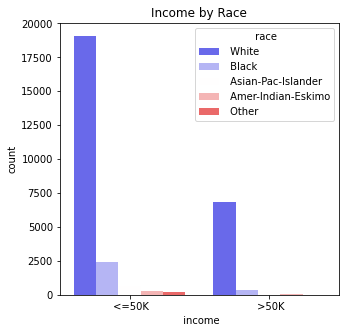

In [ ]:
f, plot = plt.subplots(figsize=(5, 5))
plot = sns.countplot(x=" income", hue=" race", data=df, palette="bwr")
plot.set_title("Income by Race")
plt.show()

We can see that "White" dominate amongst the race variable.

In [ ]:
df.corr().style.background_gradient(cmap=plt.get_cmap('bwr'), axis=1)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
age,1.000000,-0.076279,0.043203,0.080162,0.060141,0.101348
fnlwgt,-0.076279,1.000000,-0.045199,0.000420,-0.009755,-0.023033
education-num,0.043203,-0.045199,1.000000,0.124455,0.079613,0.152842
capital-gain,0.080162,0.000420,0.124455,1.000000,-0.032255,0.080429
capital-loss,0.060141,-0.009755,0.079613,-0.032255,1.000000,0.052380
hours-per-week,0.101348,-0.023033,0.152842,0.080429,0.052380,1.000000


*No strong correlation found between the numerical variables.*

#**Data Inspection**

In [ ]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,30139.000000,3.013900e+04,30139.000000,30139.000000,30139.000000,30139.000000
mean,38.441720,1.897950e+05,10.122532,1092.841202,88.439928,40.934703
std,13.131426,1.056586e+05,2.548738,7409.110596,404.445239,11.978753
min,17.000000,1.376900e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.176275e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.784170e+05,10.000000,0.000000,0.000000,40.000000
75%,47.000000,2.376045e+05,13.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


#**Data Preprocessing and Feature Selection**

In [ ]:
df_copy = df.copy()

In [ ]:
# creat dummy variables
df_copy = pd.get_dummies(df)

In [ ]:
# rename columns
df_copy = df_copy.rename(columns=({' income_ <=50K':'LowerEqual50',' income_ >50K':'Above50'}))
df_copy.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,...,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,LowerEqual50,Above50
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,38,215646,9,0,0,40,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
3,53,234721,7,0,0,40,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
4,28,338409,13,0,0,40,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
# declare feature vector and target variable
y = df_copy['Above50']
x = df_copy.drop(columns=['LowerEqual50','Above50'])
label = 'Above50'

In [ ]:
# Create a function that choose a subset of the existing features which are the most "important":

def get_best_features(x_train,y_train,num_of_features,features_names):
  selector = SelectKBest(chi2, k=num_of_features) # initiate the transformer 
  fit = selector.fit_transform(x_train, y_train) # fit it to our data
  mask = selector.get_support() # list of booleans (i.e. if the features under/above threshold (true/false))
  new_features = [] # list of K best features

  for bool, feature in zip(mask, features_names):
    if bool:
      new_features.append(feature)
  return pd.DataFrame(x_train, columns=new_features)

In [ ]:
# split the dataset
x_train, x_test, y_train,y_test = train_test_split(x,y,test_size = 0.30,random_state = 42)

In [ ]:
# extract columns names
features_names = list(x_train.columns)

In [ ]:
# balance the dataset
smote = SMOTE(random_state=42)
x_train, y_train = smote.fit_resample(x_train, y_train)

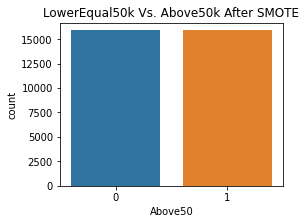

In [ ]:
# verify the dataset is balanced 
plt.figure(figsize = (4, 3))
sns.countplot(y_train) 
plt.title('LowerEqual50k Vs. Above50k After SMOTE')
plt.show()

In [ ]:
# display new dataset with the new columns (i.e. the best features)
get_best_features(x_train,y_train,50,features_names).head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-not-inc,workclass_ State-gov,...,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,sex_ Female,sex_ Male,native-country_ Mexico
0,39,181943,13,0,0,35,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,34,269723,9,2977,0,50,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
2,47,297884,6,0,0,40,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,48,147860,9,0,0,40,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
4,44,344060,15,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
# display the portion of new columns (i.e. the best features) out of total columns
len(get_best_features(x_train,y_train,50,features_names).columns)/len(df_copy.columns)

0.4716981132075472

In [ ]:
# create new dataset with the new columns (i.e. the best features)
x_train_k_sel = get_best_features(x_train,y_train,50,features_names)

#**Classification by Different Models**

In [ ]:
# create scores dataframe 
title = ['Accuracy Score','f1']
df_pred = pd.DataFrame(columns=title) 

# create function that add scores results to dataframe
def append_row(df_pred,index_name,data):
  df_pred.loc[index_name] = data

##**1.Random Forest Classifier**

##**1.1 Without Feature Selection + 100 estimators**

*Random Forest Classifier model, with 100 estimators, and without Feature Selection (i.e. using - x_train):*

In [ ]:
# instantiate the classifier 
rfc = RandomForestClassifier(random_state=0,n_estimators=100)
# fit the model
rfc.fit(x_train, y_train)

RandomForestClassifier(random_state=0)

In [ ]:
# predict with the model
y_pred = rfc.predict(x_test)
# score the model
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
# add scores results to dataframe
append_row(df_pred,'RF_100',(acc,f1))

acc

0.8530192435301924

###**1.1.1 Model Validation**

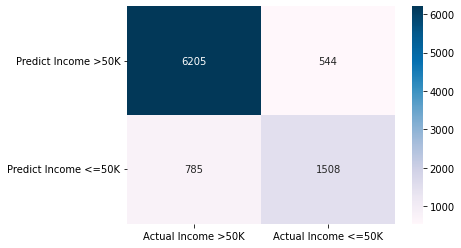

In [ ]:
con_mat = confusion_matrix(y_test,y_pred)
con_mat = pd.DataFrame(con_mat, columns=['Actual Income >50K' ,'Actual Income <=50K'], 
                                 index=['Predict Income >50K' , 'Predict Income <=50K'])
sns.heatmap(con_mat, annot=True, fmt='d', cmap='PuBu')

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90      6749
           1       0.73      0.66      0.69      2293

    accuracy                           0.85      9042
   macro avg       0.81      0.79      0.80      9042
weighted avg       0.85      0.85      0.85      9042



##**1.2 Without Feature Selection + 200 estimators**

Random Forest Classifier model, with 200 estimators, and without Feature Selection (i.e. using - x_train):

In [ ]:
# instantiate the classifier 
rfc = RandomForestClassifier(random_state=0,n_estimators=200)
# fit the model
rfc.fit(x_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=0)

In [ ]:
# predict with the model
y_pred = rfc.predict(x_test)
# score the model
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
# add scores results to dataframe
append_row(df_pred,'RF_200',(acc,f1))

acc

0.8540145985401459

###**1.2.1 Model Validation**

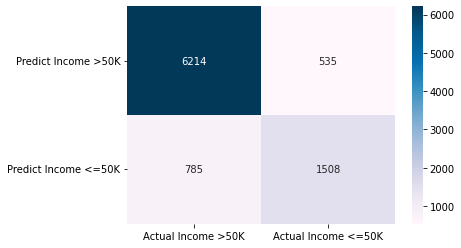

In [ ]:
con_mat = confusion_matrix(y_test,y_pred)
con_mat = pd.DataFrame(con_mat, columns=['Actual Income >50K' ,'Actual Income <=50K'], 
                                 index=['Predict Income >50K' , 'Predict Income <=50K'])
sns.heatmap(con_mat, annot=True, fmt='d', cmap='PuBu')

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90      6749
           1       0.74      0.66      0.70      2293

    accuracy                           0.85      9042
   macro avg       0.81      0.79      0.80      9042
weighted avg       0.85      0.85      0.85      9042



##**1.3 With Feature Selection + 200 estimators**

*Random Forest Classifier model, with 200 estimators, and with Feature Selection (i.e. using - x_train_k_sel):*

In [ ]:
# instantiate the classifier 
rfc = RandomForestClassifier(random_state=0,n_estimators=200)
# fit the model
rfc.fit(x_train_k_sel, y_train)

RandomForestClassifier(n_estimators=200, random_state=0)

In [ ]:
# predict with the model
y_pred = rfc.predict(x_test[list(x_train_k_sel.columns)])
# score the model
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
# add scores results to dataframe
append_row(df_pred,'RF_FS_200',(acc,f1))

acc

0.8542357885423579

###**1.3.1 Model Validation**

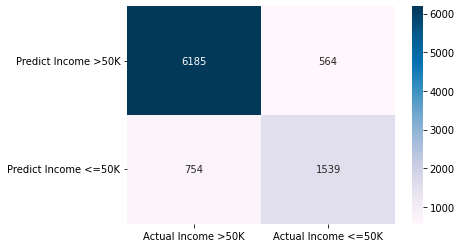

In [ ]:
con_mat = confusion_matrix(y_test,y_pred)
con_mat = pd.DataFrame(con_mat, columns=['Actual Income >50K' ,'Actual Income <=50K'], 
                                 index=['Predict Income >50K' , 'Predict Income <=50K'])
sns.heatmap(con_mat, annot=True, fmt='d', cmap='PuBu')

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90      6749
           1       0.73      0.67      0.70      2293

    accuracy                           0.85      9042
   macro avg       0.81      0.79      0.80      9042
weighted avg       0.85      0.85      0.85      9042



##**2. Gradient Boosting Classifier**

##**2.1 Without Feature Selection + 100 estimators**

*Gradient Boosting Classifier model, with 100 estimators, and without Feature Selection (i.e. using - x_train):*

In [ ]:
# instantiate the classifier 
clf_GB = GradientBoostingClassifier(max_depth=10, n_estimators=100, learning_rate=0.01)
# fit the model
clf_GB.fit(x_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, max_depth=10)

In [ ]:
# predict with the model
y_pred = clf_GB.predict(x_test)
# score the model
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
# add scores results to dataframe
append_row(df_pred,'GB_100',(acc,f1))

acc

0.8480424684804246

###**2.1.1 Model Validation**

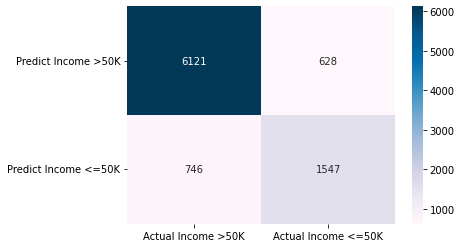

In [ ]:
con_mat = confusion_matrix(y_test,y_pred)
con_mat = pd.DataFrame(con_mat, columns=['Actual Income >50K' ,'Actual Income <=50K'], 
                                 index=['Predict Income >50K' , 'Predict Income <=50K'])
sns.heatmap(con_mat, annot=True, fmt='d', cmap='PuBu')

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      6749
           1       0.71      0.67      0.69      2293

    accuracy                           0.85      9042
   macro avg       0.80      0.79      0.80      9042
weighted avg       0.85      0.85      0.85      9042



##**2.2 Without Feature Selection + 200 estimators**

*Gradient Boosting Classifier model, with 200 estimators, and without Feature Selection (i.e. using - x_train):*

In [ ]:
# instantiate the classifier 
clf_GB = GradientBoostingClassifier(max_depth=10, n_estimators=200, learning_rate=0.01)
# fit the model
clf_GB.fit(x_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, max_depth=10, n_estimators=200)

In [ ]:
# predict with the model
y_pred = clf_GB.predict(x_test)
# score the model
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
# add scores results to dataframe
append_row(df_pred,'GB_200',(acc,f1))

acc

0.8553417385534173

###**2.2.1 Model Validation**

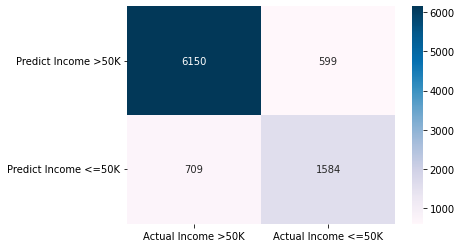

In [ ]:
con_mat = confusion_matrix(y_test,y_pred)
con_mat = pd.DataFrame(con_mat, columns=['Actual Income >50K' ,'Actual Income <=50K'], 
                                 index=['Predict Income >50K' , 'Predict Income <=50K'])
sns.heatmap(con_mat, annot=True, fmt='d', cmap='PuBu')

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.91      0.90      6749
           1       0.73      0.69      0.71      2293

    accuracy                           0.86      9042
   macro avg       0.81      0.80      0.81      9042
weighted avg       0.85      0.86      0.85      9042



##**2.3 With Feature Selection + 200 estimators**

*Gradient Boosting Classifier model, with 200 estimators, and with Feature Selection (i.e. using - x_train_k_sel):*

In [ ]:
clf_GB = GradientBoostingClassifier(max_depth=10, n_estimators=200, learning_rate=0.01)
clf_GB.fit(x_train_k_sel, y_train)

GradientBoostingClassifier(learning_rate=0.01, max_depth=10, n_estimators=200)

In [ ]:
y_pred = clf_GB.predict(x_test[list(x_train_k_sel.columns)])
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
append_row(df_pred,'GB_FS_200',(acc,f1))
acc

0.8547887635478877

###**2.3.1. Model Validation**

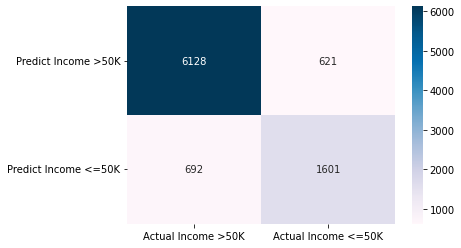

In [ ]:
con_mat = confusion_matrix(y_test,y_pred)
con_mat = pd.DataFrame(con_mat, columns=['Actual Income >50K' ,'Actual Income <=50K'], 
                                 index=['Predict Income >50K' , 'Predict Income <=50K'])
sns.heatmap(con_mat, annot=True, fmt='d', cmap='PuBu')

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.91      0.90      6749
           1       0.72      0.70      0.71      2293

    accuracy                           0.85      9042
   macro avg       0.81      0.80      0.81      9042
weighted avg       0.85      0.85      0.85      9042



#**Scoring Visualization**

In [ ]:
df_pred

,Accuracy Score,f1
RF_100,0.853019,0.694131
RF_200,0.854015,0.695572
RF_FS_200,0.854236,0.700182
GB_100,0.848042,0.692480
GB_200,0.855342,0.707775
GB_FS_200,0.854789,0.709192


Text(0, 0.5, 'Score')

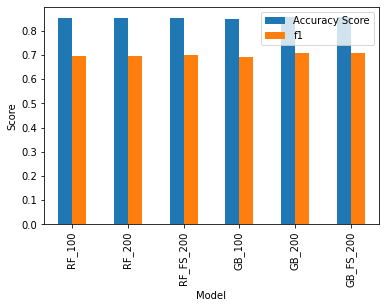

In [ ]:
plot = df_pred.rename_axis(index='Model').plot.bar()
plot.set_ylabel('Score')

## **Results and Conclusions**

1. In this project, in order to predict whether a person makes over 50K a year, I built 2 models and applied 3 different approaches:
  * *Models - Random Forest Classifier and Gradient Boosting Classifier*
  * *Approaches - 100 estimators, 200 estimators and 200 estimators with features selection.*
2. The score of the models, as expected, increased with number of decision-trees in the model.
  * *Both in terms of accuracy and f1 score.*
3. Training the model only on portion of the columns (features selection), surprisingly, caused an improvment only in the Random Forest model.
4. Confusion matrix and classification report are attached as well to visualize the models performance.
5. The best performing model with the highest accuracy and f1 score is - Gradient Boosting Classifier with 200 estimators.

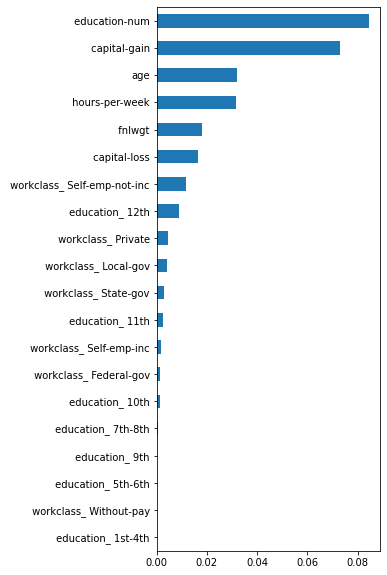

In [ ]:
# features importance of the best model (Random Forest Classifier)
pd.Series(clf_GB.feature_importances_, index=x_train.columns).head(20).sort_values().plot.barh(figsize=(4, 10), rot=0)